In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_palette(sns.color_palette('Set2')[::2])
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column,is_probing_location_better
from common import lang2code, code2lang, lang2family, family2langs

figure_dir = "fig/tokenization"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [34]:
exps = pd.read_table("../dataframes/all_char_experiments.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])
exps1 = add_probing_location_better_column(exps)

In [35]:
exps = pd.read_table("../dataframes/all_r2l_experiments.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])
exps2 = add_probing_location_better_column(exps)

In [36]:
exps = pd.concat([exps1, exps2], ignore_index=True)

## Load fertility and majority baseline

In [37]:
fertility = pd.read_table("../dataframes/task_fertility.tsv")
fertility.shape

(319, 14)

In [38]:
old_len = len(exps)

exps = exps.merge(fertility, on=['language', 'task'], how='inner')

if old_len != len(exps):
    raise ValueError(f"Merging with fertility dataframe changed the number of rows: {old_len} --> {len(exps)}")

# Model perturbations

In [39]:
model_perturbations = [
    'mBERT-r2l',
    'mBERT-char',
    'mBERT-rand-subw', 
    'mBERT-rand-r2l',
    'mBERT-rand-char'
]

models = ['mBERT'] + model_perturbations

baselines = exps[
    ((exps.model=='mBERT') & (exps.perturbation.isnull())) |
    ((exps.model=='mBERT') & (exps.perturbation.isin(model_perturbations)))
]
baselines = baselines[baselines['probing_location_better']==True].copy()
baselines

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,...,majority_baseline,sentence_char_len,sentence_char_per_subword,sentence_fertility,sentence_subword_len,sentence_word_len,target_char_len,target_char_per_subword,target_fertility,target_subw_entropy
1,mBERT,Afrikaans,number_noun,NaN,last,97.20,95.30,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
3,mBERT,Afrikaans,number_noun,mBERT-char,last,92.30,90.65,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
5,mBERT,Afrikaans,number_noun,mBERT-rand-char,last,88.00,85.15,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
7,mBERT,Afrikaans,number_noun,mBERT-rand-subw,last,81.10,83.80,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
9,mBERT,Afrikaans,number_noun,mBERT-r2l,last,93.50,96.00,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,mBERT,Urdu,number_noun,mBERT-char,last,95.95,88.05,number,noun,Urdu number_noun,...,59.0,91.90875,2.063353,1.751543,44.729583,25.56500,5.624583,2.006330,3.035417,7.210958
3821,mBERT,Urdu,number_noun,mBERT-rand-char,last,89.05,81.60,number,noun,Urdu number_noun,...,59.0,91.90875,2.063353,1.751543,44.729583,25.56500,5.624583,2.006330,3.035417,7.210958
3823,mBERT,Urdu,number_noun,mBERT-rand-subw,last,91.40,84.50,number,noun,Urdu number_noun,...,59.0,91.90875,2.063353,1.751543,44.729583,25.56500,5.624583,2.006330,3.035417,7.210958
3825,mBERT,Urdu,number_noun,mBERT-r2l,last,95.00,89.00,number,noun,Urdu number_noun,...,59.0,91.90875,2.063353,1.751543,44.729583,25.56500,5.624583,2.006330,3.035417,7.210958


In [40]:
baselines['model2'] = None

baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isnull()), 'model2'] = 'mBERT'
baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(model_perturbations)), 'model2'] = \
    baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(model_perturbations)), 'perturbation']

In [41]:
baselines['model'] = baselines['model2']
baselines.head()

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,...,sentence_char_len,sentence_char_per_subword,sentence_fertility,sentence_subword_len,sentence_word_len,target_char_len,target_char_per_subword,target_fertility,target_subw_entropy,model2
1,mBERT,Afrikaans,number_noun,NaN,last,97.2,95.30,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT
3,mBERT-char,Afrikaans,number_noun,mBERT-char,last,92.3,90.65,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT-char
5,mBERT-rand-char,Afrikaans,number_noun,mBERT-rand-char,last,88.0,85.15,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT-rand-char
7,mBERT-rand-subw,Afrikaans,number_noun,mBERT-rand-subw,last,81.1,83.80,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT-rand-subw
9,mBERT-r2l,Afrikaans,number_noun,mBERT-r2l,last,93.5,96.00,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT-r2l


In [42]:
if set(baselines['model'].unique()) != set(models):
    raise ValueError(f"Models missing from data?\n{baselines['model'].unique()} vs. {models}")

In [43]:
set(models) - set(baselines['model'].unique())
baselines['model'].unique()

array(['mBERT', 'mBERT-char', 'mBERT-rand-char', 'mBERT-rand-subw',
       'mBERT-r2l', 'mBERT-rand-r2l'], dtype=object)

In [44]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
means = b.groupby('model').mean().sort_values('test_acc')
means / means.loc['mBERT']

,dev_acc,test_acc
model,,
mBERT-rand-char,0.784310,0.769586
mBERT-rand-r2l,-0.010673,0.803677
mBERT-rand-subw,0.820482,0.807032
mBERT-char,0.927420,0.921437
mBERT-r2l,0.957250,0.954505
mBERT,1.000000,1.000000


In [45]:
d = b.pivot_table(index=['language', 'task'], columns='model', values='test_acc')
d

model                        mBERT  mBERT-char  mBERT-r2l  mBERT-rand-char  \
language  task                                                               
Afrikaans number_noun    95.300000   90.650000  96.000000        85.150000   
Albanian  case_noun      69.350000   64.100000  65.000000        54.450000   
          case_propn     83.050000   80.800000  79.500000        72.850000   
          definite_noun  90.600000   85.750000  86.500000        76.700000   
          gender_noun    86.200000   84.000000  87.000000        71.250000   
...                            ...         ...        ...              ...   
Ukrainian tense_verb     87.412935   77.064677  88.059701        56.865672   
Urdu      case_noun      87.450000   85.150000  81.000000        57.150000   
          case_propn     87.100000   87.800000  84.500000        55.850000   
          gender_noun    76.300000   74.550000  75.500000        73.400000   
          number_noun    92.850000   88.050000  89.000000        81.600000   

model                    mBERT-rand-r2l  mBERT-rand-subw  
language  task                                            
Afrikaans number_noun              83.5        83.800000  
Albanian  case_noun                40.5        53.750000  
          case_propn               69.5        74.650000  
          definite_noun            54.0        78.750000  
          gender_noun              70.5        72.400000  
...                                 ...              ...  
Ukrainian tense_verb               73.0        70.597015  
Urdu      case_noun                51.0        50.900000  
          case_propn               59.0        56.650000  
          gender_noun              68.0        72.900000  
          number_noun              84.0        84.500000  

[319 rows x 6 columns]

In [46]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
b['pos'] = b['task'].apply(lambda t: t.split('_')[1])

all_mean = b.groupby('model').mean().reset_index()
all_mean['pos'] = 'ALL'

b = b.groupby(['model', 'pos']).mean().reset_index()

b = pd.concat((b, all_mean))
b.pos = b.pos.str.upper()

pos_order = ['ALL', 'NOUN', 'PROPN', 'VERB', 'ADJ']

b.pos = pd.Categorical(b.pos, ordered=True, categories=pos_order)
b

,model,pos,dev_acc,test_acc
0,mBERT,ADJ,94.671440,92.869636
1,mBERT,NOUN,93.089110,91.453573
2,mBERT,PROPN,86.841865,83.179514
3,mBERT,VERB,94.832479,92.789641
4,mBERT-char,ADJ,86.978345,84.964518
5,mBERT-char,NOUN,84.503119,82.367335
6,mBERT-char,PROPN,75.902699,71.987276
7,mBERT-char,VERB,90.731406,88.218050
8,mBERT-r2l,ADJ,89.021435,87.178599
9,mBERT-r2l,NOUN,88.510798,86.172679


In [47]:
majority = baselines.groupby(['pos', 'language', 'task'])['majority_baseline'].mean().groupby('pos').mean()
majority.loc['all'] = baselines.groupby(['language', 'task'])['majority_baseline'].mean().mean()
majority.index = majority.index.str.upper()
majority

pos
ADJ      43.787395
NOUN     42.314139
PROPN    37.491294
VERB     41.594590
ALL      42.038970
Name: majority_baseline, dtype: float64

## Bar chart

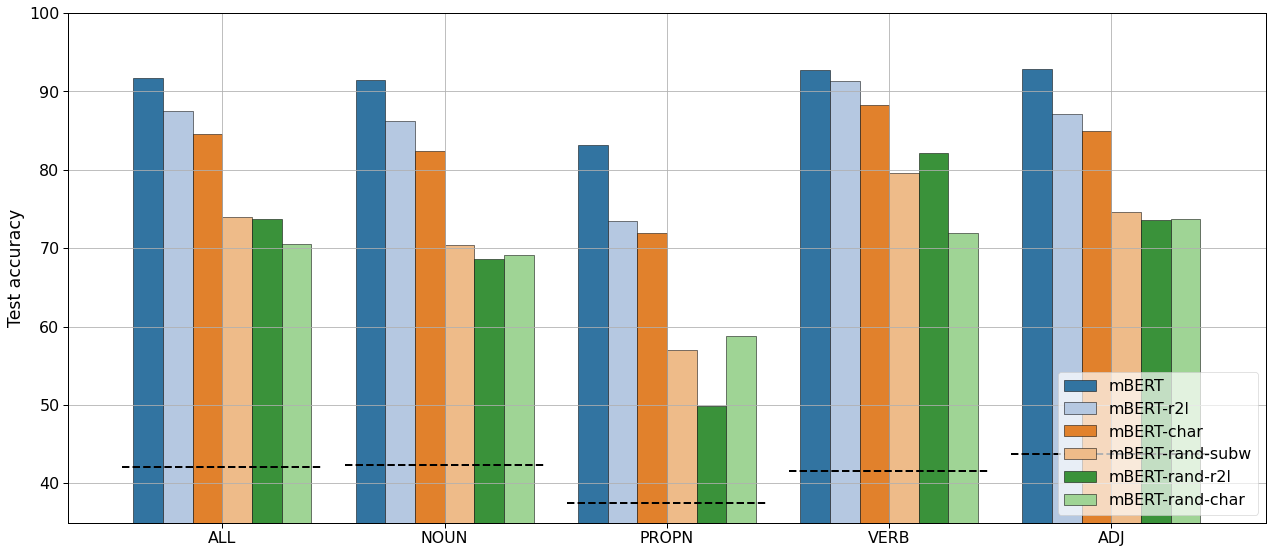

In [48]:
model_order = ['mBERT'] + model_perturbations
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(18, 8), facecolor='w')
    sns.barplot(x=b.pos, y=b.test_acc, hue=b.model, hue_order=model_order, 
                palette='tab20',
                ci=None,
                edgecolor='black', linewidth=.5, ax=ax)
    ax.set_ylim(35, 100)
    ax.set_xlabel("")
    ax.set_ylabel("Test accuracy")
    ax.grid(True)
    ax.legend(title="", loc='lower right', framealpha=0.7, fancybox=True)
    
    for pi, p in enumerate(pos_order):
        yval = majority.loc[p]
        ax.plot((pi-0.45, pi+0.45), (yval, yval), linestyle='dashed', linewidth=2, color='black')
        
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/bar_bert_r2l.pdf", dpi=600)

# Results


## Tokenization

### mBERT-rand

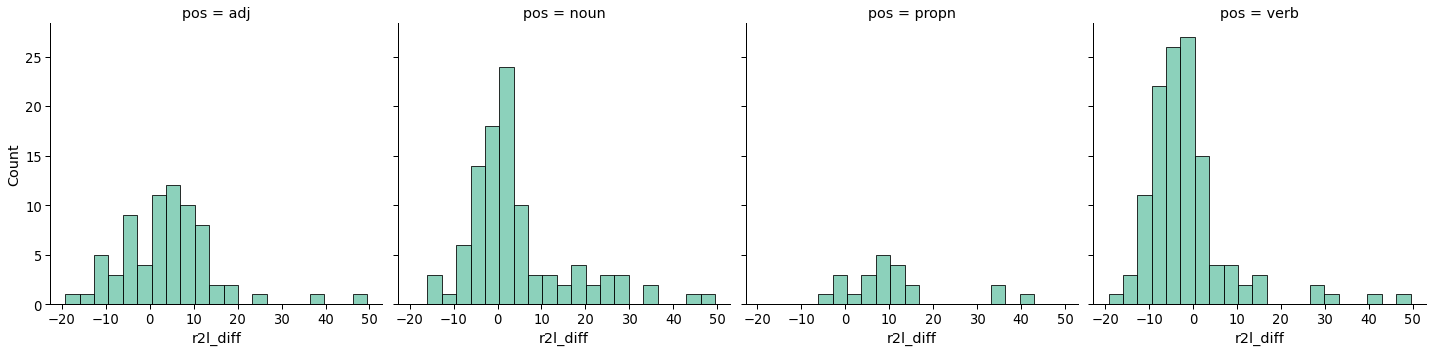

In [57]:
def get_diff(r2l, s, c):
    m = max([s, c])
    return m - r2l

df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    (exps.perturbation.isin(('mBERT-rand-subw', 'mBERT-rand-r2l', 
                             'mBERT-rand-char')))
].groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
diff_col_name = 'r2l_diff'
df["r2l_diff"] = df.apply(lambda x : get_diff(x['mBERT-rand-r2l'],
                                             x['mBERT-rand-subw'], x['mBERT-rand-char']), axis=1)
sns.displot(data=df, x=diff_col_name, col='pos')

In [58]:
df.groupby('language')[diff_col_name].mean().sort_values()

language
Finnish             -10.340906
Turkish              -6.926392
Latin                -6.496805
Estonian             -5.779038
Basque               -5.333333
Hungarian            -3.550000
Lithuanian           -3.293627
Armenian             -2.350000
Latvian              -1.800948
Bulgarian            -0.113320
Ukrainian             0.338274
Slovenian             1.136778
Danish                1.375522
Persian               1.550000
Afrikaans             1.650000
Russian               1.799601
Urdu                  2.425000
Romanian              2.794303
Catalan               2.803527
Hindi                 2.833333
Italian               2.968750
Polish                3.119627
Norwegian_Bokmal      3.989303
Croatian              4.060526
Swedish               4.756250
Norwegian_Nynorsk     5.123738
Slovak                5.860572
Greek                 6.372438
French                7.090986
German                7.130439
Spanish               7.178571
Czech                 7.828495

In [59]:
df[df.r2l_diff<0].r2l_diff.describe()

count    152.000000
mean      -5.649285
std        3.825521
min      -19.214286
25%       -7.785821
50%       -4.797015
75%       -2.737500
max       -0.250000
Name: r2l_diff, dtype: float64

In [60]:
df[df.r2l_diff<0].sort_values("r2l_diff")

perturbation,pos,language,task,mBERT-rand-char,mBERT-rand-r2l,mBERT-rand-subw,r2l_diff
229,verb,Finnish,case_verb,28.095238,85.5,66.285714,-19.214286
25,adj,Finnish,derivation_adj,25.350000,75.5,57.800000,-17.700000
259,verb,Latin,tense_verb,34.975124,64.5,48.905473,-15.594527
103,noun,Finnish,case_noun,36.169154,78.0,62.537313,-15.462687
254,verb,Latin,case_verb,44.702970,74.5,59.801980,-14.698020
...,...,...,...,...,...,...,...
109,noun,German,gender_noun,51.890547,52.5,47.611940,-0.609453
281,verb,Polish,verbform_verb,78.168317,86.0,85.396040,-0.603960
63,adj,Slovenian,case_adj,50.049751,61.0,60.547264,-0.452736
34,adj,Italian,number_adj,82.650000,83.0,77.900000,-0.350000


In [61]:
finnish = df[df.language=="Finnish"].sort_values("r2l_diff").reset_index()
finnish2 = finnish.merge(fertility[fertility.language=="Finnish"], on=['language', 'task'], how='inner')
finnish2[["language", "task", "r2l_diff", "target_fertility"]]

,language,task,r2l_diff,target_fertility
0,Finnish,case_verb,-19.214286,3.615512
1,Finnish,derivation_adj,-17.700000,3.817083
2,Finnish,case_noun,-15.462687,3.898052
3,Finnish,derivation_noun,-13.200000,3.987099
4,Finnish,number_adj,-12.000000,3.564583
5,Finnish,degree_adj,-11.308458,3.630987
6,Finnish,partform_verb,-11.144279,3.594673
7,Finnish,infform_verb,-9.783582,3.286428
8,Finnish,mood_verb,-9.706468,3.093217
9,Finnish,voice_verb,-9.500000,3.358333


In [80]:
def fertility_plot(lang):
    lang_df = df[df.language==lang].sort_values("r2l_diff").reset_index()
    lang_df = lang_df.merge(fertility[fertility.language==lang], on=['language', 'task'], how='inner')
    lang_df[["language", "task", "r2l_diff", "target_fertility"]]
    ax = sns.lmplot(data=lang_df, x="target_fertility", y="r2l_diff")
    ax.fig.suptitle(f"language = {lang}")
    ax.savefig(f"{figure_dir}/{lang}_reg.pdf")

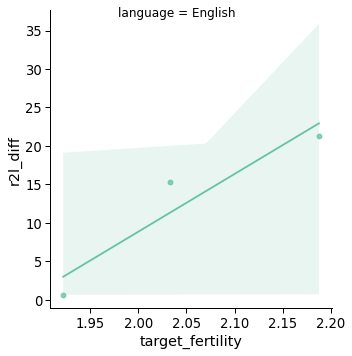

In [85]:
fertility_plot("English")

### mBERT

In [53]:
def get_diff(r2l, s, c):
    m = max([s, c])
    return m - r2l

df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    ((exps.perturbation=='mBERT-r2l')
     | (exps.perturbation.isnull()) | (exps.perturbation=='mBERT-char'))
].copy()
df['perturbation'] = df['perturbation'].fillna('mBERT')
df = df.groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
diff_col_name = 'r2l_diff'
df["r2l_diff"] = df.apply(lambda x : get_diff(x['mBERT-r2l'], 
                                             x['mBERT'], x['mBERT-char']), axis=1)

In [54]:
df.groupby('language')[diff_col_name].mean().sort_values()

language
Finnish              -1.051886
Turkish              -0.974640
Latin                -0.849990
Afrikaans            -0.700000
Estonian             -0.185663
Basque                0.282616
Spanish               0.964286
Hungarian             1.366667
Catalan               1.661262
Portuguese            1.725000
Romanian              1.729055
Bulgarian             1.918024
Latvian               2.047170
Albanian              2.242857
French                2.802192
Italian               2.893750
Lithuanian            3.013235
Greek                 3.185572
Urdu                  3.600000
Danish                3.644129
Persian               3.650000
Armenian              4.200000
Norwegian_Nynorsk     4.235039
Norwegian_Bokmal      4.438024
Swedish               4.650000
Hebrew                4.669606
Arabic                4.763101
English               4.800000
Ukrainian             5.348769
Croatian              6.221509
Czech                 6.833500
Hindi                 6.933333

In [55]:
df[df.r2l_diff<0].r2l_diff.describe()

count    60.000000
mean     -1.487474
std       1.686268
min      -9.800995
25%      -2.341231
50%      -0.750000
75%      -0.337500
max      -0.049751
Name: r2l_diff, dtype: float64

In [56]:
df[df.r2l_diff<0].sort_values("r2l_diff").reset_index()

perturbation,index,pos,language,task,mBERT,mBERT-char,mBERT-r2l,r2l_diff
0,259,verb,Latin,tense_verb,67.810945,58.905473,77.611940,-9.800995
1,303,verb,Slovenian,aspect_verb,76.800000,65.100000,82.500000,-5.700000
2,314,verb,Turkish,polarity_verb,83.200000,67.700000,88.500000,-5.300000
3,25,adj,Finnish,derivation_adj,89.300000,68.000000,93.500000,-4.200000
4,103,noun,Finnish,case_noun,89.303483,80.796020,92.537313,-3.233831
5,236,verb,Finnish,voice_verb,87.850000,77.750000,91.000000,-3.150000
6,226,verb,Estonian,tense_verb,90.750000,86.600000,93.500000,-2.750000
7,258,verb,Latin,person_verb,94.776119,94.825871,97.512438,-2.686567
8,262,verb,Latvian,definite_verb,94.850000,93.900000,97.500000,-2.650000
9,230,verb,Finnish,infform_verb,95.373134,89.701493,98.009950,-2.636816
